In [1]:
import os

N_CORES = 4
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={N_CORES}"


import jax.numpy as jnp
from jax import random, vmap
import jax
from jax.scipy.special import logit

from tqdm import tqdm
import numpy as np
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, leaves_list

import Simulations.data_gen as dg
from src.MWG_sampler import MWG_sampler, MWG_init
import src.utils as utils
from src.Models import cond_logpost_a_star, triu_star_grad_fn

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['savefig.facecolor'] = 'white'





In [2]:
# Global variables (as in mwg_simulation.py)

N = 500
TRIU_DIM = N * (N - 1) // 2

THETA = jnp.array([-2.5, 1])
# GAMMA_F = jnp.array([logit(0.85), logit(0.1)])
GAMMA_BASELINE = jnp.array([logit(0.95), logit(0.05)])
# GAMMA_BASELINE = jnp.array([logit(0.98), logit(0.02)])

# GAMMA_REP = jnp.array([logit(0.8), 1, logit(0.2), 1])
GAMMA_REP = jnp.array([logit(0.8), 1.5, logit(0.2), 1.5])
# GAMMA_X_NOISES = jnp.arange(1, 3.5 + 1e-6, 0.5)
GAMMA_X_NOISES = jnp.arange(2, 4 + 1e-6, 0.5)

GAMMA_B_NOISE_0 = GAMMA_BASELINE[0] - GAMMA_X_NOISES / 2
GAMMA_B_NOISE_1 = GAMMA_BASELINE[1] + GAMMA_X_NOISES / 2

# ETA = jnp.array([-1, 3, -0.25, 2])
ETA = jnp.array([-1, 3, -0.5, 2])
SIG_INV = 1.0
RHO = 0.5
PZ = 0.5


PARAM = {
    "theta": THETA,
    "eta": ETA,
    "rho": RHO,
    "sig_inv": SIG_INV,
}

# Take mid value of GAMMA_X_NOISES for illustration

cur_gamma = jnp.concatenate(
                # [GAMMA_F, jnp.array([GAMMA_X_NOISES[j]]), GAMMA_REP]
                [
                    jnp.array([GAMMA_B_NOISE_0[2]]),
                    jnp.array([GAMMA_B_NOISE_1[2]]),
                    jnp.array([GAMMA_X_NOISES[2]]),
                    GAMMA_REP,
                ]
            )

print(cur_gamma)



[ 1.4444387 -1.4444389  3.         1.3862945  1.5       -1.3862944
  1.5      ]


In [3]:
# rng_key = random.PRNGKey(1159)
rng_key = random.PRNGKey(0)

# generate data (not depedent on gamma)
rng_key, _ = random.split(rng_key)
fixed_data = dg.generate_fixed_data(rng_key, N, PARAM, PZ)

# true_vals for wasserstein distance
true_vals = {
    "eta": ETA,
    "rho": jnp.array([RHO]),
    "sig_inv": jnp.array([SIG_INV]),
    "triu_star": fixed_data["triu_star"],
}

print(f"mean true exposures: {jnp.mean(fixed_data['true_exposures']):.3f}")

# generate new interventions
rng_key, _ = random.split(rng_key)
new_interventions = dg.new_interventions_estimands(
    rng_key, N, fixed_data["x"], fixed_data["triu_star"], ETA
)

print(f"mean dynamic estimands: {jnp.mean(new_interventions.estimand_h):.3f}")
print(f"mean stochastic estimands: {jnp.mean(new_interventions.estimand_stoch):.3f}")

mean true exposures: 2.549
mean dynamic estimands: 4.123
mean stochastic estimands: 5.401


In [4]:
rng_key = random.split(rng_key)[0]
# sample proxy networks with current gamma
proxy_nets = dg.generate_proxy_networks(
    # rng,
    rng_key,
    TRIU_DIM,
    fixed_data["triu_star"],
    cur_gamma,
    fixed_data["x_diff"],
    fixed_data["Z"],
)

data_sim = dg.data_for_sim(fixed_data, proxy_nets)


In [26]:
# --- MWG init params (single proxy) ---

rng_key = random.split(rng_key)[1]
mwg_init = MWG_init(
    rng_key=rng_key,
    data=data_sim,
    n_iter_networks=1000,
).get_init_values()

# --- Sampling with MWG (single proxy) ---

rng_key = random.split(rng_key)[1]

mwg_sampler = MWG_sampler(
    rng_key=rng_key,
    data=data_sim,
    init_params=mwg_init,
    n_warmup=5,
    n_samples=15
)



Initializing parameters for MWG sampler...
MWG init params: 
 theta: [-0.03691842  1.1114908 ] 
 gamma: [ 1.6392689  -0.40608156 -1.1158228 ] 
 eta: [-0.42599788  2.9115822  -0.49681833  0.03292456] 
 rho: 0.31497076 
 sig_inv: 0.0016707069


In [41]:
post_mean_probs = jnp.mean(mwg_sampler.posterior_samples["triu_star"], axis=0)

In [30]:
def plot_heatmaps(true_net, obs_net, post_mean_net):
    """
    Plot two heatmaps side by side:
    - Left: Posterior mean probabilities of edges in the latent adjacency.
    - Right: True adjacency matrix of the latent layer.
    
    Arguments:
    - posterior_probs: n x n matrix of posterior mean probabilities (values in [0,1]).
    - true_values: n x n binary adjacency matrix (values in {0,1}).
    """
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    
    # Heatmap of posterior mean probabilities
    sns.heatmap(true_net, ax=axes[0], cmap="coolwarm", vmin=0, vmax=1, annot=False)
    axes[0].set_title("True")
    
    # Heatmap of true adjacency matrix
    sns.heatmap(obs_net, ax=axes[1], cmap="coolwarm", vmin=0, vmax=1, annot=False)
    axes[1].set_title("Observed")

    # Heatmap of posterior mean probabilities
    sns.heatmap(post_mean_net, ax=axes[2], cmap="coolwarm", vmin=0, vmax=1, annot=False)
    axes[2].set_title("Posterior mean")
    
    plt.tight_layout()
    plt.show()

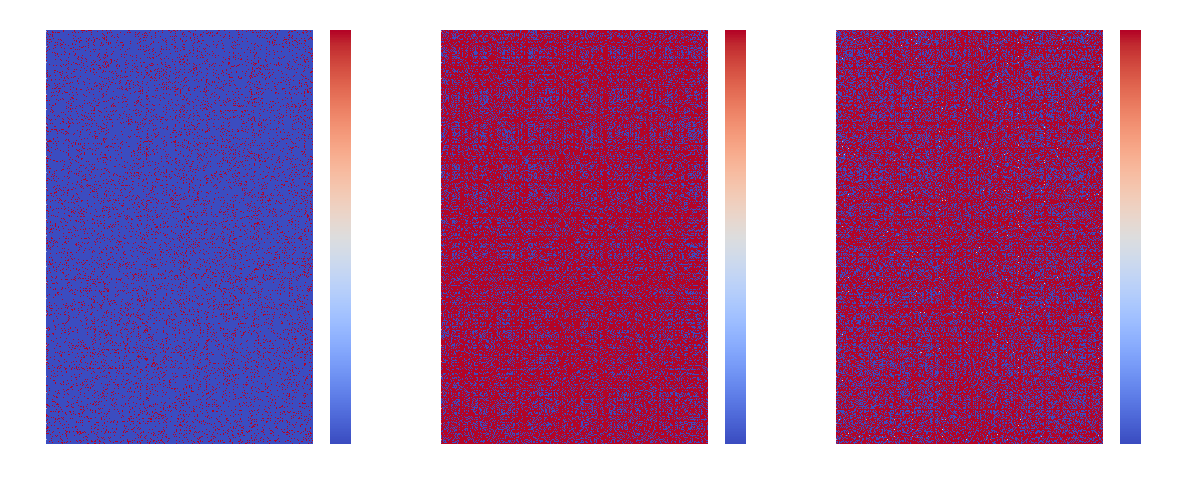

In [62]:
true_net = utils.Triu_to_mat(data_sim.triu_star)
obs_net = utils.Triu_to_mat(data_sim.triu_obs)
# obs_net = utils.Triu_to_mat(data_sim.triu_obs_rep)
post_mean = utils.Triu_to_mat(post_mean_probs)

plot_heatmaps(true_net, obs_net, post_mean)


In [45]:
print(f"triu_star mean: {jnp.mean(data_sim.triu_star):.3f}", "\n",
      f"triu_obs mean: {jnp.mean(data_sim.triu_obs):.3f}", "\n",
      f"triu_obs mean: {jnp.mean(data_sim.triu_obs_rep):.3f}", "\n",
      f"posterior mean mean: {jnp.mean(post_mean_probs):.3f}")

triu_star mean: 0.099 
 triu_obs mean: 0.729 
 triu_obs mean: 0.487 
 posterior mean mean: 0.668


In [63]:
# 1. Convert true network to numpy for scipy-based clustering
true_net_np = np.array(true_net)  # SciPy needs a NumPy array

# 2. Compute distances and linkage on the *rows* of true network
distances = pdist(true_net_np, metric='euclidean') 
Z = linkage(distances, method='ward')            
node_order = leaves_list(Z)                     

# 3. Apply the ordering to rows and columns in all matrices 
node_order_jax = jnp.array(node_order)

true_ordered = true_net[node_order_jax][:, node_order_jax]
observed_ordered = obs_net[node_order_jax][:, node_order_jax]
posterior_ordered = post_mean[node_order_jax][:, node_order_jax]


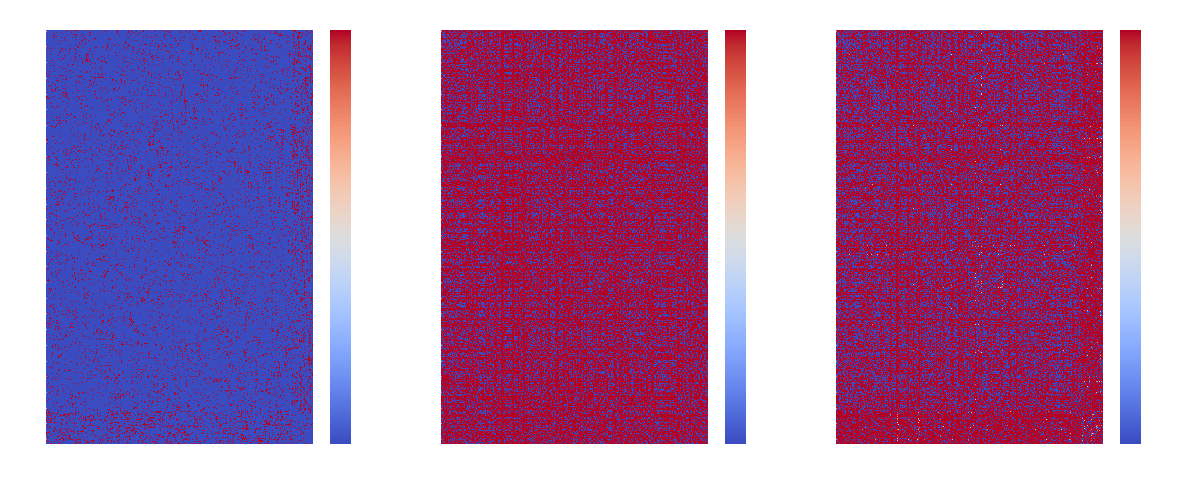

In [36]:
plot_heatmaps(true_ordered, observed_ordered, posterior_ordered)

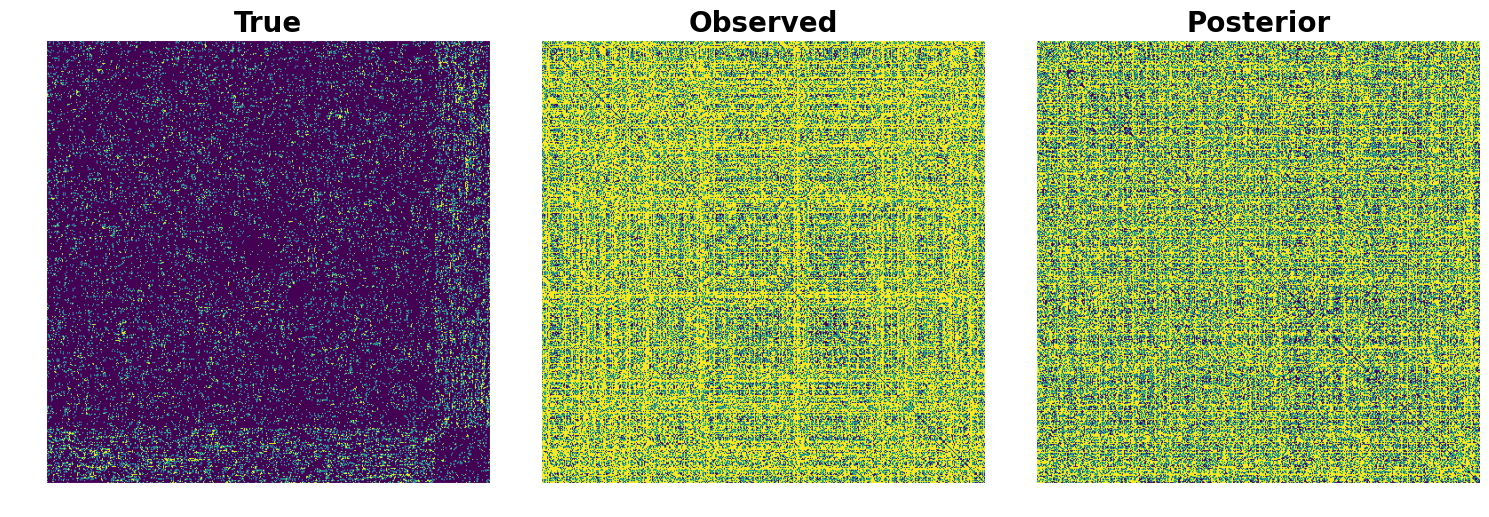

In [64]:
# 4. Plot the three reordered matrices side by side
#    Matplotlib’s imshow expects NumPy arrays, so we convert each to NumPy

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im1 = axes[0].imshow(np.array(true_ordered))
axes[0].set_title("True", color="black", fontsize=20, fontweight="bold")
# plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(np.array(observed_ordered))
axes[1].set_title("Observed", color="black", fontsize=20, fontweight="bold")
# plt.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(np.array(posterior_ordered))
axes[2].set_title("Posterior", color="black",  fontsize=20, fontweight="bold")
# plt.colorbar(im3, ax=axes[2])

# cbar = plt.colorbar(im3, ax=axes[2])
# cbar.set_label('Edge value')

plt.tight_layout()
plt.show()

(array([1.0000e+01, 2.8000e+01, 5.7000e+01, 1.6600e+02, 3.1300e+02,
        6.5700e+02, 1.1730e+03, 1.8510e+03, 2.6140e+03, 3.0360e+03,
        2.8720e+03, 1.7300e+03, 8.7800e+02, 1.3810e+03, 3.8010e+03,
        7.8670e+03, 1.1195e+04, 6.6990e+03, 1.0690e+03, 1.7000e+01,
        0.0000e+00, 0.0000e+00, 7.4560e+03, 9.0900e+03, 0.0000e+00,
        8.0000e+02, 1.4785e+04, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        2.2900e+02, 2.7650e+03, 8.9450e+03, 9.5240e+03, 5.8360e+03,
        2.4000e+03, 8.2500e+02, 1.0010e+03, 1.9200e+03, 2.7170e+03,
        2.8410e+03, 2.3650e+03, 1.7030e+03, 1.0490e+03, 6.0300e+02,
        2.9100e+02, 1.1600e+02, 5.7000e+01, 1.0000e+01, 7.0000e+00]),
 array([-48137.08203125, -46184.359375  , -44231.640625  , -42278.921875  ,
        -40326.19921875, -38373.4765625 , -36420.7578125 , -34468.0390625 ,
        -32515.31640625, -30562.59570312, -28609.875     , -26657.15429688,
        -24704.43359375, -22751.71289062, -20798.9921875 , -18846.27148438,
        -16893

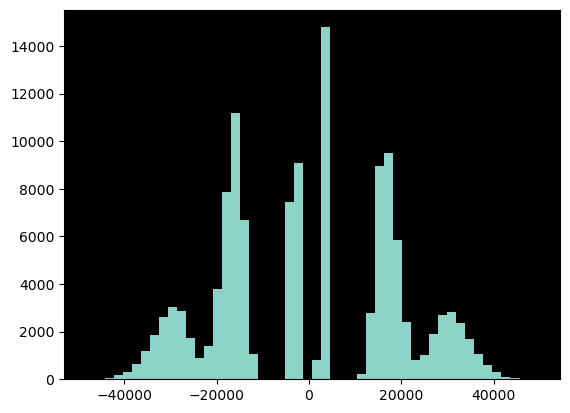

In [29]:
# --- Locally informed proposal ---
# test how well gradients approximate the true differences


params = utils.ParamTuple(
    theta=THETA,
    gamma=cur_gamma,
    eta=ETA,
    rho=RHO,
    sig_inv=SIG_INV,
)

_, grads = triu_star_grad_fn(data_sim.triu_obs_rep, data_sim, params)
# _, grads = triu_star_grad_fn(data_sim.triu_star, data_sim, params)
# score_grad = -(2*data_sim.triu_star-1)*grads/2
score_grad = -(2*data_sim.triu_obs_rep-1)*grads/2

plt.hist(score_grad, bins=50)

In [30]:
def flip_val(x):
    return jnp.where(x == 0.0, 1.0, 0.0)

@jax.jit
def single_flip_logpost(i, triu, data, param):
    flipped = triu.at[i].set(flip_val(triu[i]))
    return cond_logpost_a_star(flipped, data, param)


score_logdensity = jnp.zeros(TRIU_DIM) 
# for i in tqdm(range(TRIU_DIM)):
for i in tqdm(range(3000)):
    score_logdensity = score_logdensity.at[i].set(
        single_flip_logpost(i, data_sim.triu_obs_rep, data_sim, params)
        # single_flip_logpost(i, data_sim.triu_obs, data_sim, params)
        # single_flip_logpost(i, data_sim.triu_star, data_sim, params)
        )

baseline = cond_logpost_a_star(data_sim.triu_obs_rep, data_sim, params)
# baseline = cond_logpost_a_star(data_sim.triu_obs, data_sim, params)
# baseline = cond_logpost_a_star(data_sim.triu_star, data_sim, params)
score_diffs = score_logdensity - baseline



100%|██████████| 3000/3000 [01:16<00:00, 38.99it/s]


In [17]:
matplotlib.rcParams['xtick.color'] = 'black'
matplotlib.rcParams['ytick.color'] = 'black'
matplotlib.rcParams['axes.labelcolor'] = 'black'
matplotlib.rcParams['axes.edgecolor'] = 'black'
matplotlib.rcParams['axes.titlesize'] = 'large'
matplotlib.rcParams['axes.labelsize'] = 'medium'

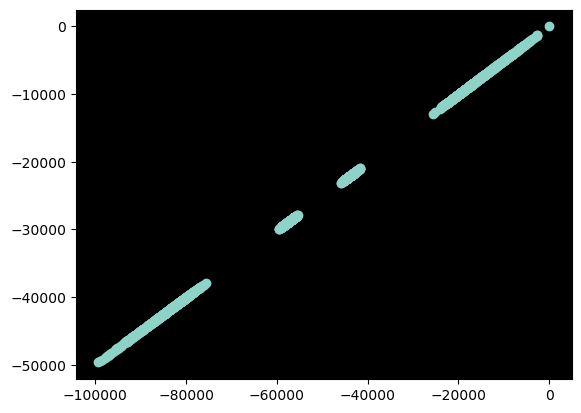

In [34]:
# plt.scatter(score_diffs[:3000], score_grad[:3000])
plt.scatter(jax.nn.log_softmax(score_diffs[:3000]), jax.nn.log_softmax(score_grad[:3000]))


((124750,),
 dtype('float32'),
 (124750,),
 dtype('float32'),
 (124750,),
 dtype('float32'))